In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'breast-ultrasound-images-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1209633%2F2021025%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240509%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240509T183957Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9241a1c1db6d496f50eb017cac2ffe03455b557839166f4534e05dc43eb26517c77da1f5fc0146953f14e9406aae3c58a4dfe5d1521e16497115da548e4e1806fc87f4dfacbd4ea64ff6493a6f7813d27a8ad799156d635f40d1d2d1e071949e1ec4158d26feff73216e4cba6c2fe21c317416c5a4543c35f70ab027290d1c74328e112abe9de54f348bd5ccdb6b3b5d72de2c391d8d951515c3f3f8a7510208f2a243020dc4a8d0fbaea9509575d54b9a0fc2bb418171e91f57c56c4a3ec04182491d5569a166659e307e1593b20c815e2d122eaeeee67a67175091e66b0c5b84458f09d2fb3152729d6d7e77a928e665922caf269f191fe5ca10f6892fba21'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from PIL import Image
import shutil

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import random
from sklearn.model_selection import train_test_split

import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, ColorJitter

<ipython-input-61-5e5c73c8fd93>:20: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((desired_width, desired_height), Image.ANTIALIAS)


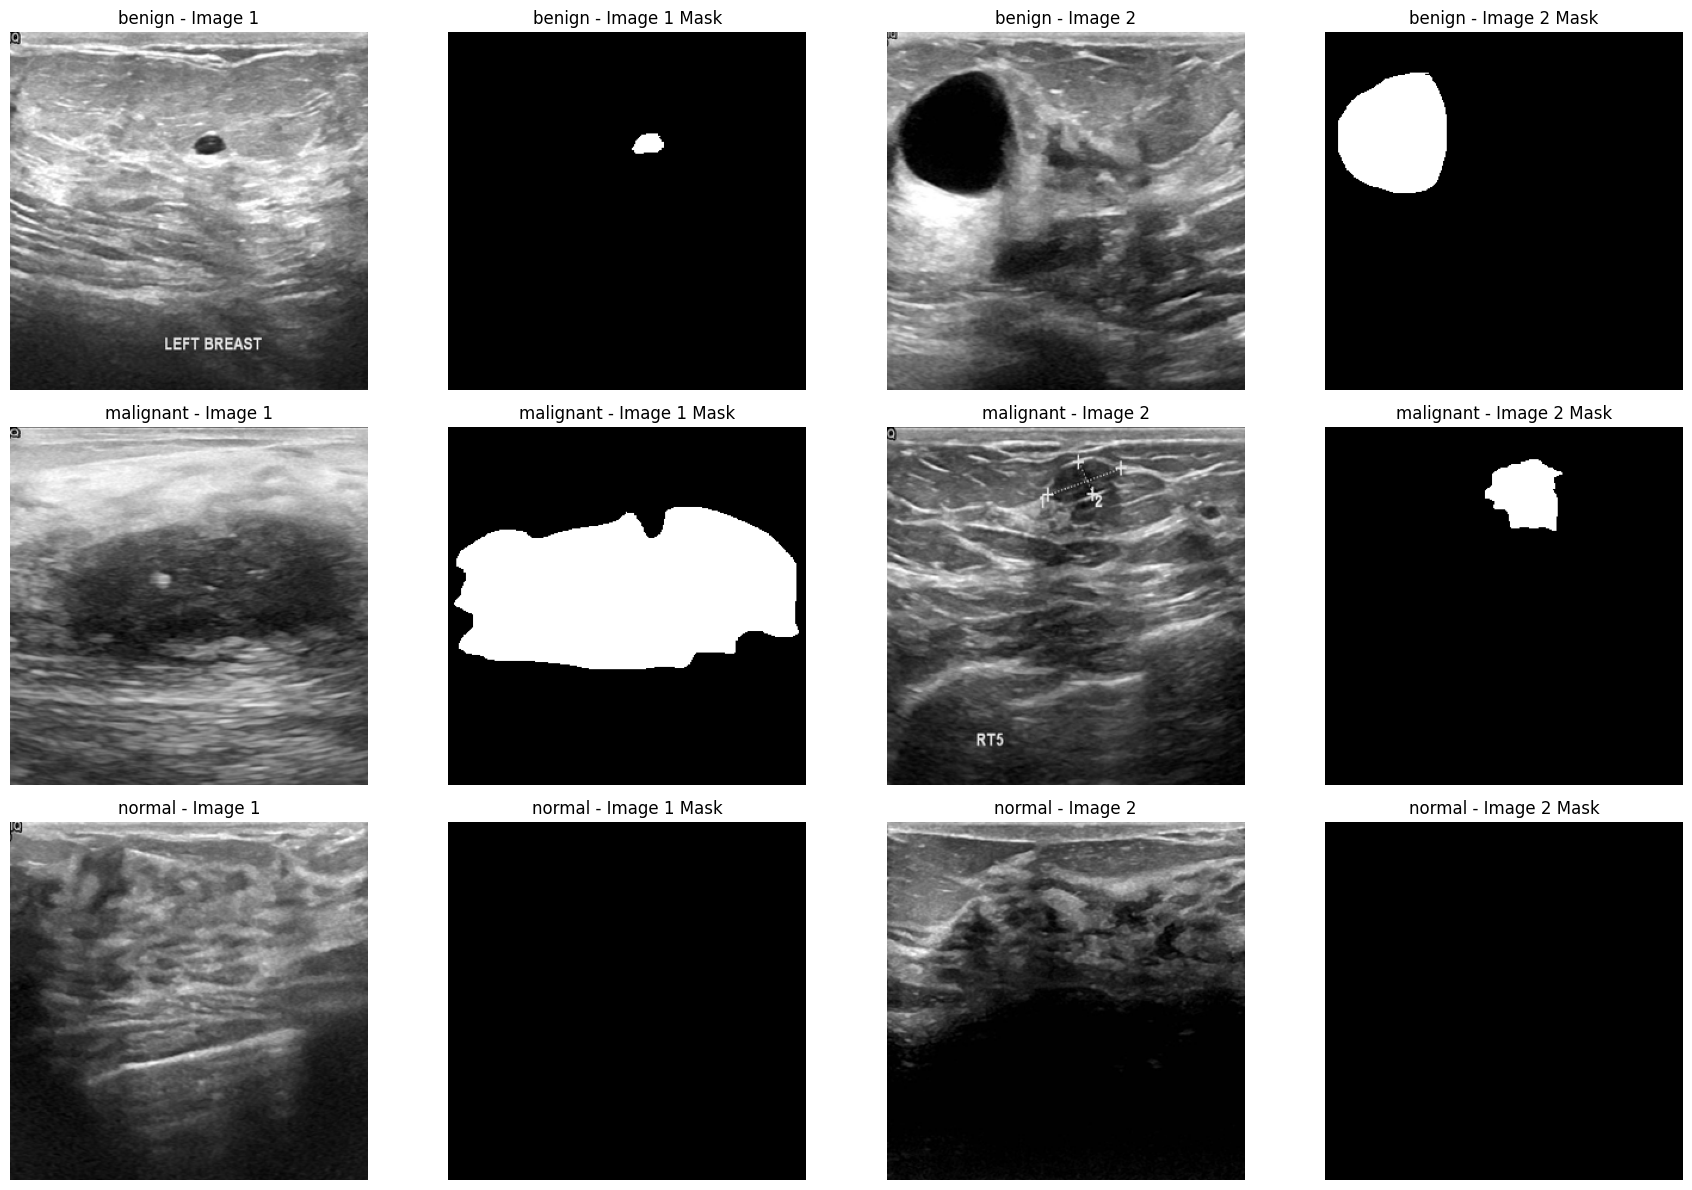

In [ ]:
labels = ['benign', 'malignant', 'normal']
data_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'

fig, axs = plt.subplots(3, 4, figsize=(18, 12))

desired_width = 300
desired_height = 300

for i, label in enumerate(labels):
    label_dir = os.path.join(data_dir, label)

    image_files = [file for file in os.listdir(label_dir) if file.endswith('.png')]

    image_files = sorted(image_files)

    for j in range(4):
        if j < len(image_files):
            image_path = os.path.join(label_dir, image_files[j])
            image = Image.open(image_path)
            image = image.resize((desired_width, desired_height), Image.ANTIALIAS)

            if j % 2 == 0:
                image_label = f'{label} - Image {j // 2 + 1}'
            else:
                image_label = f'{label} - Image {j // 2 + 1} Mask'

            axs[i, j].imshow(image)
            axs[i, j].set_title(image_label)
            axs[i, j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
class_names = ['malignant', 'normal','benign']
minority_classes = ['malignant', 'normal']

minority_class_transforms = transforms.Compose([
    RandomHorizontalFlip(p=0.9),
    RandomRotation(15, expand=False, center=None),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomApply([minority_class_transforms], p=0.5) if any(cls in minority_classes for cls in class_names) else transforms.RandomApply([], p=0.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Approach 1

In [ ]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

data_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'

file_paths = []
labels = []

for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for image_file in os.listdir(label_dir):
            if image_file.endswith('.png') and not (image_file.endswith('_mask.png') or
                                                     image_file.endswith('_mask_1.png') or
                                                     image_file.endswith('_mask_2.png')):
                image_path = os.path.join(label_dir, image_file)
                labels.append(label)
                file_paths.append(image_path)

data = pd.DataFrame({'Image_Path': file_paths, 'Label': labels})

train_data, test_data = train_test_split(data, test_size=0.15, random_state=42, stratify=data['Label'])
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42, stratify=train_data['Label'])

train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/validation'
test_dir = '/kaggle/working/test'

for label in labels:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

for _, row in train_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(train_dir, label))

for _, row in val_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(val_dir, label))

for _, row in test_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(test_dir, label))

In [ ]:
import os
train_dir = '/kaggle/working/train'

subdirectories = ['benign', 'malignant', 'normal']

file_counts = {}

for subdirectory in subdirectories:
    subdirectory_path = os.path.join(train_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

for category, count in file_counts.items():
    print(f"Train {category}: {count}")

validation_dir = '/kaggle/working/validation'

subdirectories = ['benign', 'malignant', 'normal']

file_counts = {}

for subdirectory in subdirectories:
    subdirectory_path = os.path.join(validation_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

for category, count in file_counts.items():
    print(f"Validation {category}: {count}")

test_dir = '/kaggle/working/test'

subdirectories = ['benign', 'malignant', 'normal']

file_counts = {}

for subdirectory in subdirectories:
    subdirectory_path = os.path.join(test_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

for category, count in file_counts.items():
    print(f"test {category}: {count}")

Train benign: 315
Train malignant: 152
Train normal: 96
Validation benign: 56
Validation malignant: 27
Validation normal: 17
test benign: 66
test malignant: 31
test normal: 20


<ipython-input-65-6f477ad3b402>:18: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((desired_width, desired_height), Image.ANTIALIAS)


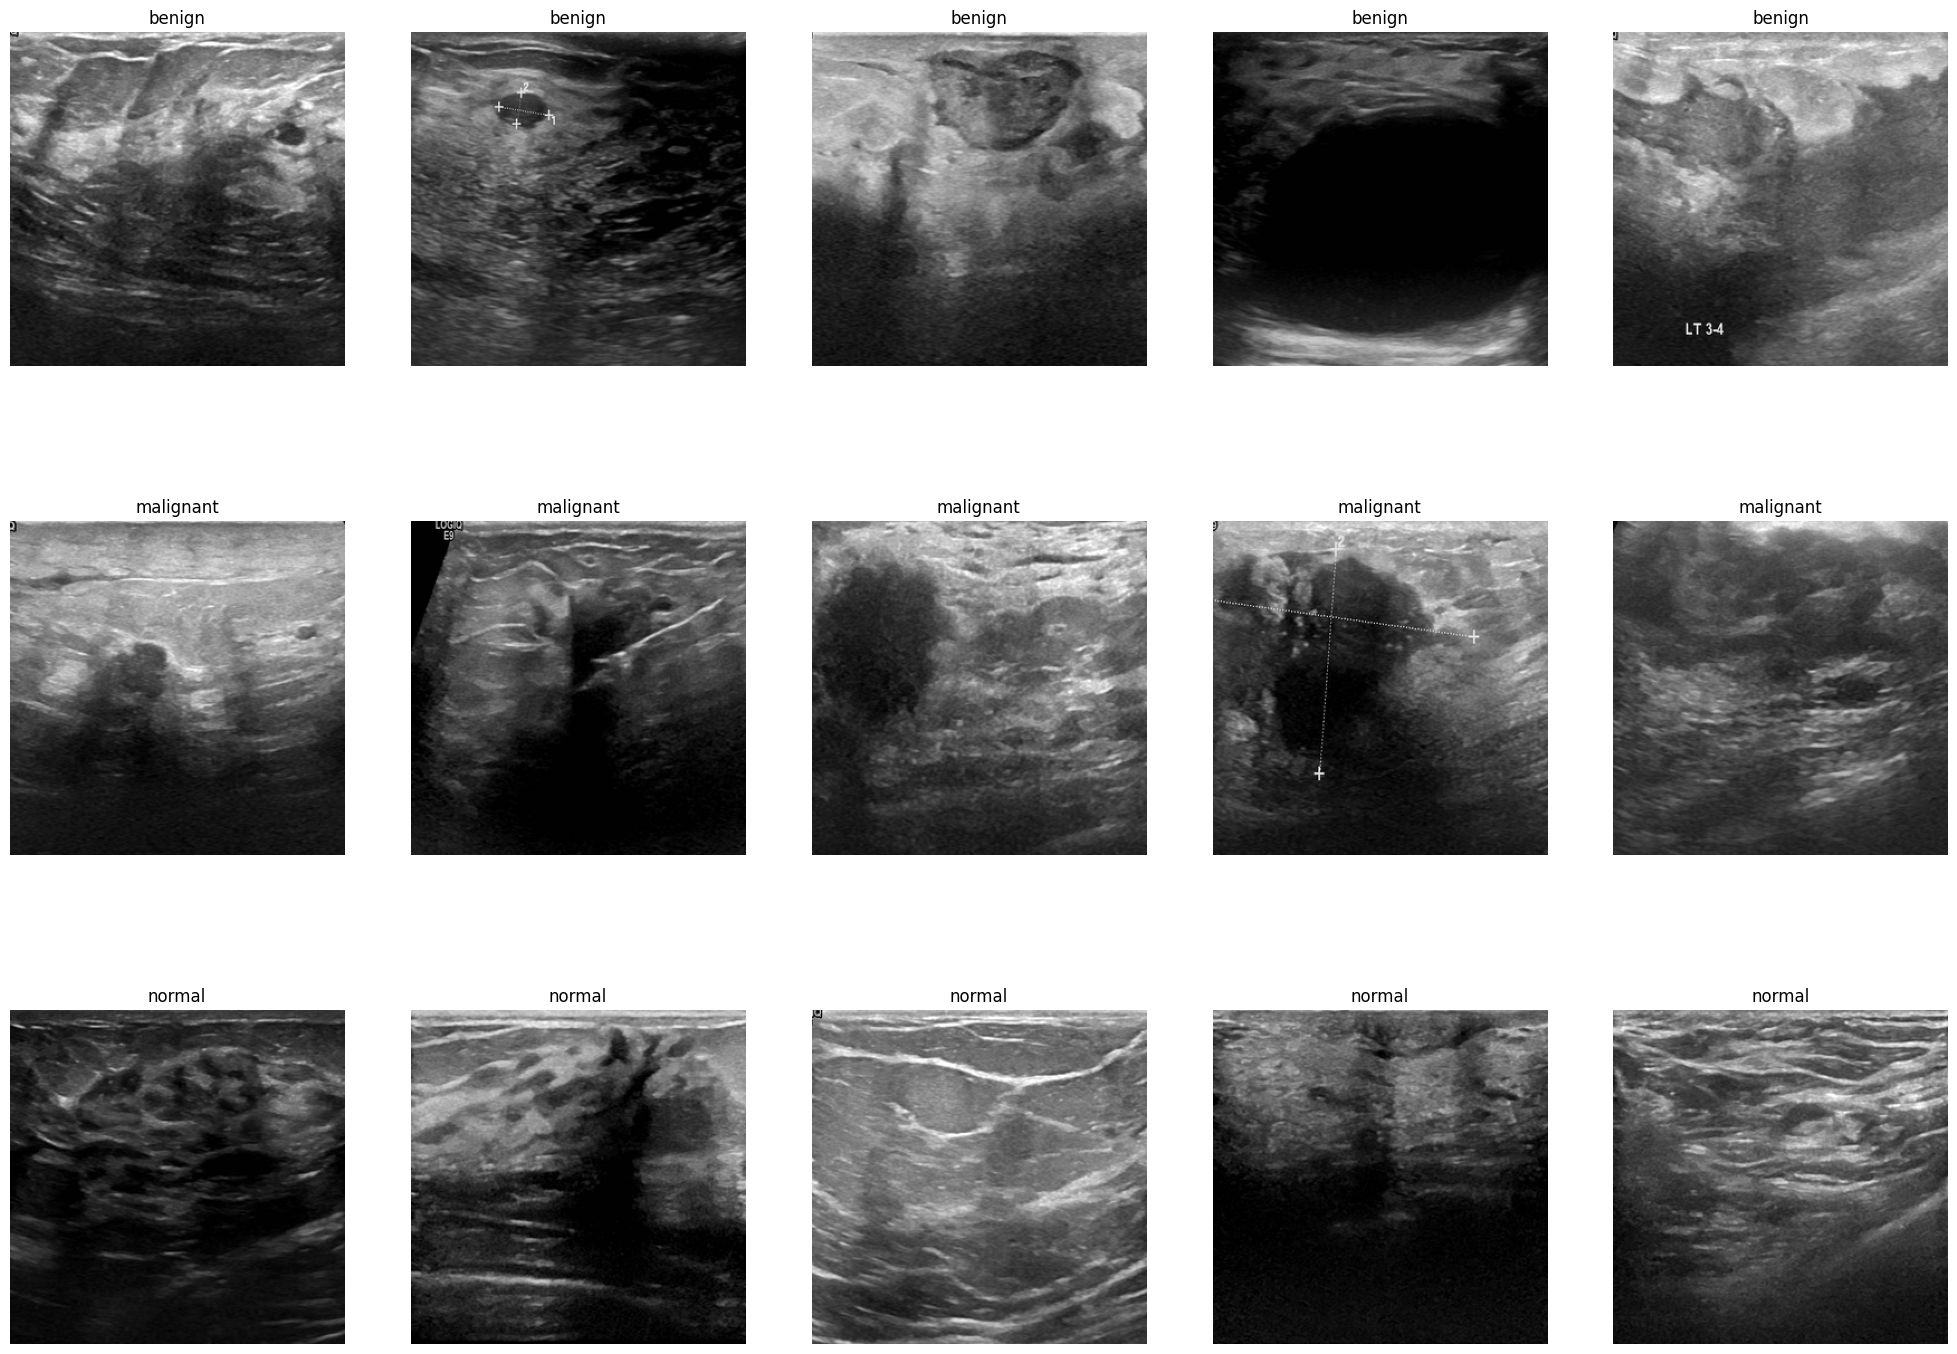

In [ ]:
train_dir = '/kaggle/working/train'

labels = ['benign', 'malignant', 'normal']
label_dirs = [os.path.join(train_dir, label) for label in labels]

fig, axs = plt.subplots(3, 5, figsize=(25, 18))

desired_width = 300
desired_height = 300

for i, label_dir in enumerate(label_dirs):
    images = [image for image in os.listdir(label_dir) if not image.endswith('_mask.png')][:5]

    for j, image_filename in enumerate(images):
        image_path = os.path.join(label_dir, image_filename)
        image = Image.open(image_path)

        image = image.resize((desired_width, desired_height), Image.ANTIALIAS)

        axs[i, j].imshow(image)
        axs[i, j].set_title(labels[i])
        axs[i, j].axis('off')

plt.show()

In [ ]:
data_dir='/kaggle/working/'

image_datasets = {
    x: ImageFolder(
        root=os.path.join(data_dir, x),
        transform=data_transforms[x]
    )
    for x in ['train', 'validation', 'test']
}

batch_size = 8

dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
               for x in ['train', 'validation', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}

class_names = image_datasets['train'].classes

print("Dataset Sizes:", dataset_sizes)
print("Class Labels:", class_names)

Dataset Sizes: {'train': 563, 'validation': 100, 'test': 117}
Class Labels: ['benign', 'malignant', 'normal']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
def train_model_with_early_stopping(model, lossFunction, optimizer, scheduler, dataloaders, dataset_sizes, class_names, device, num_epochs=20, patience=2):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    consecutive_epochs_without_improvement = 0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = lossFunction(outputs, labels)

                    if phase == 'train':
                        train_losses.append(loss.item())
                        train_acc = torch.sum(preds == labels.data)
                        train_accuracies.append(train_acc.item() / inputs.size(0))
                    else:
                        val_losses.append(loss.item())
                        val_acc = torch.sum(preds == labels.data)
                        val_accuracies.append(val_acc.item() / inputs.size(0))

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += inputs.size(0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / total_samples

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'validation':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    consecutive_epochs_without_improvement = 0
                else:
                    consecutive_epochs_without_improvement += 1

        if consecutive_epochs_without_improvement >= patience:
            print(f"Early stopping after {epoch} epochs")
            break

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:.4f}'.format(best_loss))

    model.load_state_dict(best_model_wts)

    y_true = []
    y_pred = []

    model.eval()

    with torch.no_grad():
        for inputs, labels in dataloaders['validation']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    target_names = [str(class_names[i]) for i in range(len(class_names))]
    print(classification_report(y_true, y_pred, target_names=target_names))

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    return model, train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
Resnet101 = models.resnet101(weights=True)

print(Resnet101)

for param in Resnet101.parameters():
    param.requires_grad = True

in_features = Resnet101.fc.in_features

Resnet101.fc = nn.Linear(in_features, len(class_names))

Resnet_fineTuning = Resnet101.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
optimizer = optim.Adam(Resnet_fineTuning.parameters(), lr=0.00005)

Decay_Learning_Rate = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Loss_Function = nn.CrossEntropyLoss()

In [ ]:
model_fineTuning, train_losses, train_accuracies, val_losses, val_accuracies = train_model_with_early_stopping(
    Resnet_fineTuning, Loss_Function, optimizer, Decay_Learning_Rate,
    dataloaders, dataset_sizes, class_names, device, num_epochs=20, patience=2)
torch.save(model_fineTuning, "/kaggle/working/Resnet_fineTuning.pth")

Epoch 0/19
----------


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


train Loss: 0.7391 Acc: 0.6785
validation Loss: 0.4245 Acc: 0.8500

Epoch 1/19
----------
train Loss: 0.4998 Acc: 0.8011
validation Loss: 0.4367 Acc: 0.8400

Epoch 2/19
----------
train Loss: 0.3512 Acc: 0.8739
validation Loss: 0.4041 Acc: 0.8000

Epoch 3/19
----------
train Loss: 0.3159 Acc: 0.8721
validation Loss: 0.2130 Acc: 0.9300

Epoch 4/19
----------
train Loss: 0.2853 Acc: 0.8970
validation Loss: 0.3071 Acc: 0.8900

Epoch 5/19
----------
train Loss: 0.2721 Acc: 0.9112
validation Loss: 0.2112 Acc: 0.9200

Epoch 6/19
----------
train Loss: 0.1939 Acc: 0.9378
validation Loss: 0.2245 Acc: 0.8900

Epoch 7/19
----------
train Loss: 0.1363 Acc: 0.9591
validation Loss: 0.1949 Acc: 0.9300

Epoch 8/19
----------
train Loss: 0.1525 Acc: 0.9538
validation Loss: 0.1813 Acc: 0.9200

Epoch 9/19
----------
train Loss: 0.1460 Acc: 0.9467
validation Loss: 0.2144 Acc: 0.9100

Epoch 10/19
----------
train Loss: 0.1127 Acc: 0.9698
validation Loss: 0.2090 Acc: 0.9100
Early stopping after 10 epochs
T

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


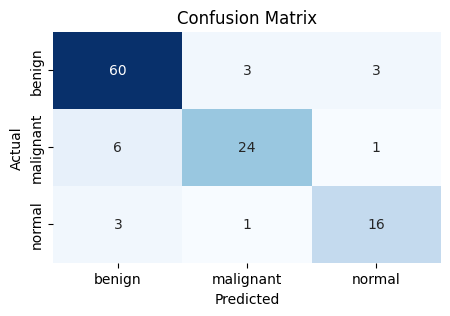

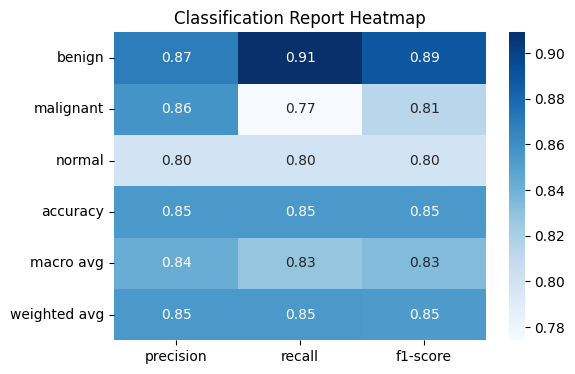

Simplified Classification Report:
             benign  malignant  normal  accuracy  macro avg  weighted avg
precision  0.869565   0.857143     0.8  0.854701   0.842236      0.854382
recall     0.909091   0.774194     0.8  0.854701   0.827761      0.854701
f1-score   0.888889   0.813559     0.8  0.854701   0.834149      0.853735


In [ ]:
label_names = [str(class_names[i]) for i in range(len(class_names))]

y_true = []
y_pred = []

model_fineTuning.eval()

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_fineTuning(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

classification_rep = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)

confusion_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(6, 4))
sns.heatmap(pd.DataFrame(classification_rep).iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f')
plt.title('Classification Report Heatmap')
plt.show()

print("Simplified Classification Report:")
print(pd.DataFrame(classification_rep).iloc[:-1, :])


1.0788520574569702 1.0591143369674683 1.0870962142944336 1.0658406019210815 1.0630520582199097 0.9887298941612244 0.9417023658752441 0.9446821808815002 0.8797903656959534 0.9283798336982727 0.8623921871185303 0.7420573234558105 0.8665531873703003 0.9437191486358643 1.055318832397461 0.610424280166626 0.7931877374649048 0.7199128866195679 0.8155321478843689 0.784026563167572 0.5099446773529053 1.0545082092285156 0.6218990087509155 0.683648407459259 0.43660539388656616 0.7521486878395081 0.8133044838905334 0.4576929807662964 0.8616833686828613 0.5076435208320618 0.6601994633674622 1.389819860458374 0.49575498700141907 0.6309497952461243 1.1911723613739014 0.3500228524208069 0.9905556440353394 0.560581624507904 0.8111451268196106 0.6773393154144287 0.3109644055366516 0.9619765877723694 0.7688796520233154 0.6983059048652649 0.39828360080718994 0.6166601777076721 0.7098556756973267 0.2545511722564697 0.9291496872901917 0.4790049195289612 0.605143666267395 0.6534021496772766 0.43724939227104

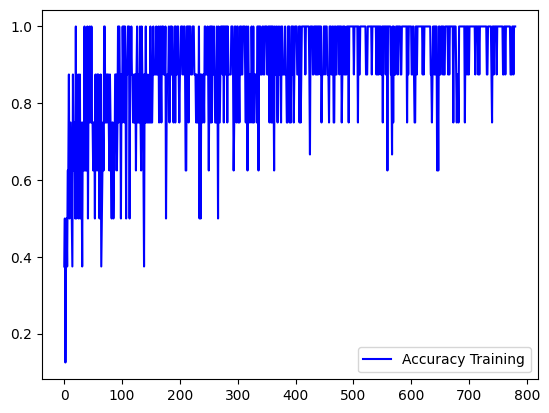

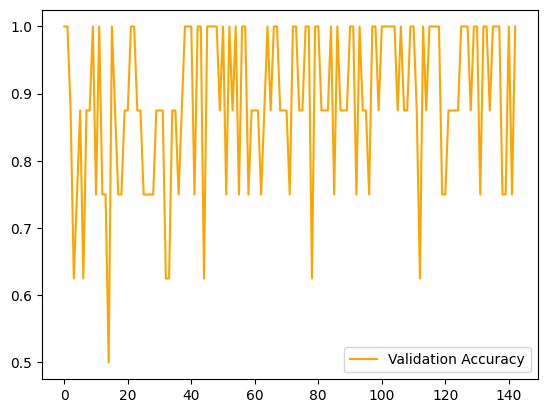

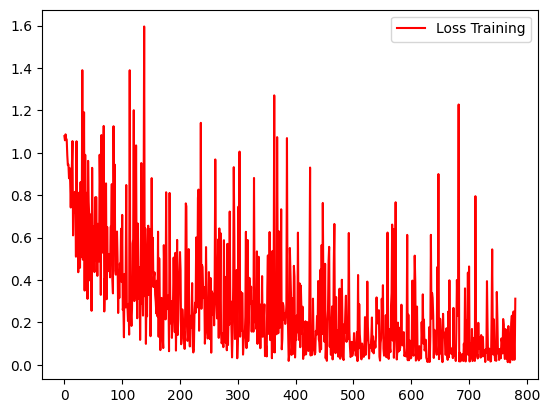

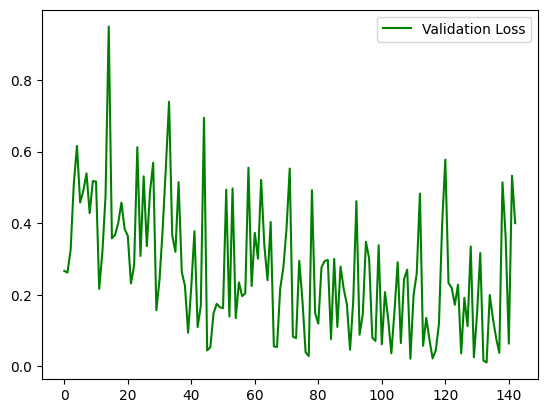

In [ ]:
#train_losses, train_accuracies, val_losses, val_accuracies
import matplotlib.pyplot as plt

print(*train_losses)
print(len(train_losses))
print(*train_accuracies)
print(len(train_accuracies))
print(*val_losses)
print(len(val_losses))
print(*val_accuracies)
print(len(val_accuracies))


plt.plot(train_accuracies,label="Accuracy Training",color='blue')
plt.legend()
plt.show()
print("\n")
plt.plot(val_accuracies,label="Validation Accuracy",color='orange')
plt.legend()
plt.show()
print("\n")
plt.plot(train_losses,label="Loss Training",color='red')
plt.legend()
plt.show()
print("\n")
plt.plot(val_losses,label="Validation Loss",color='green')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


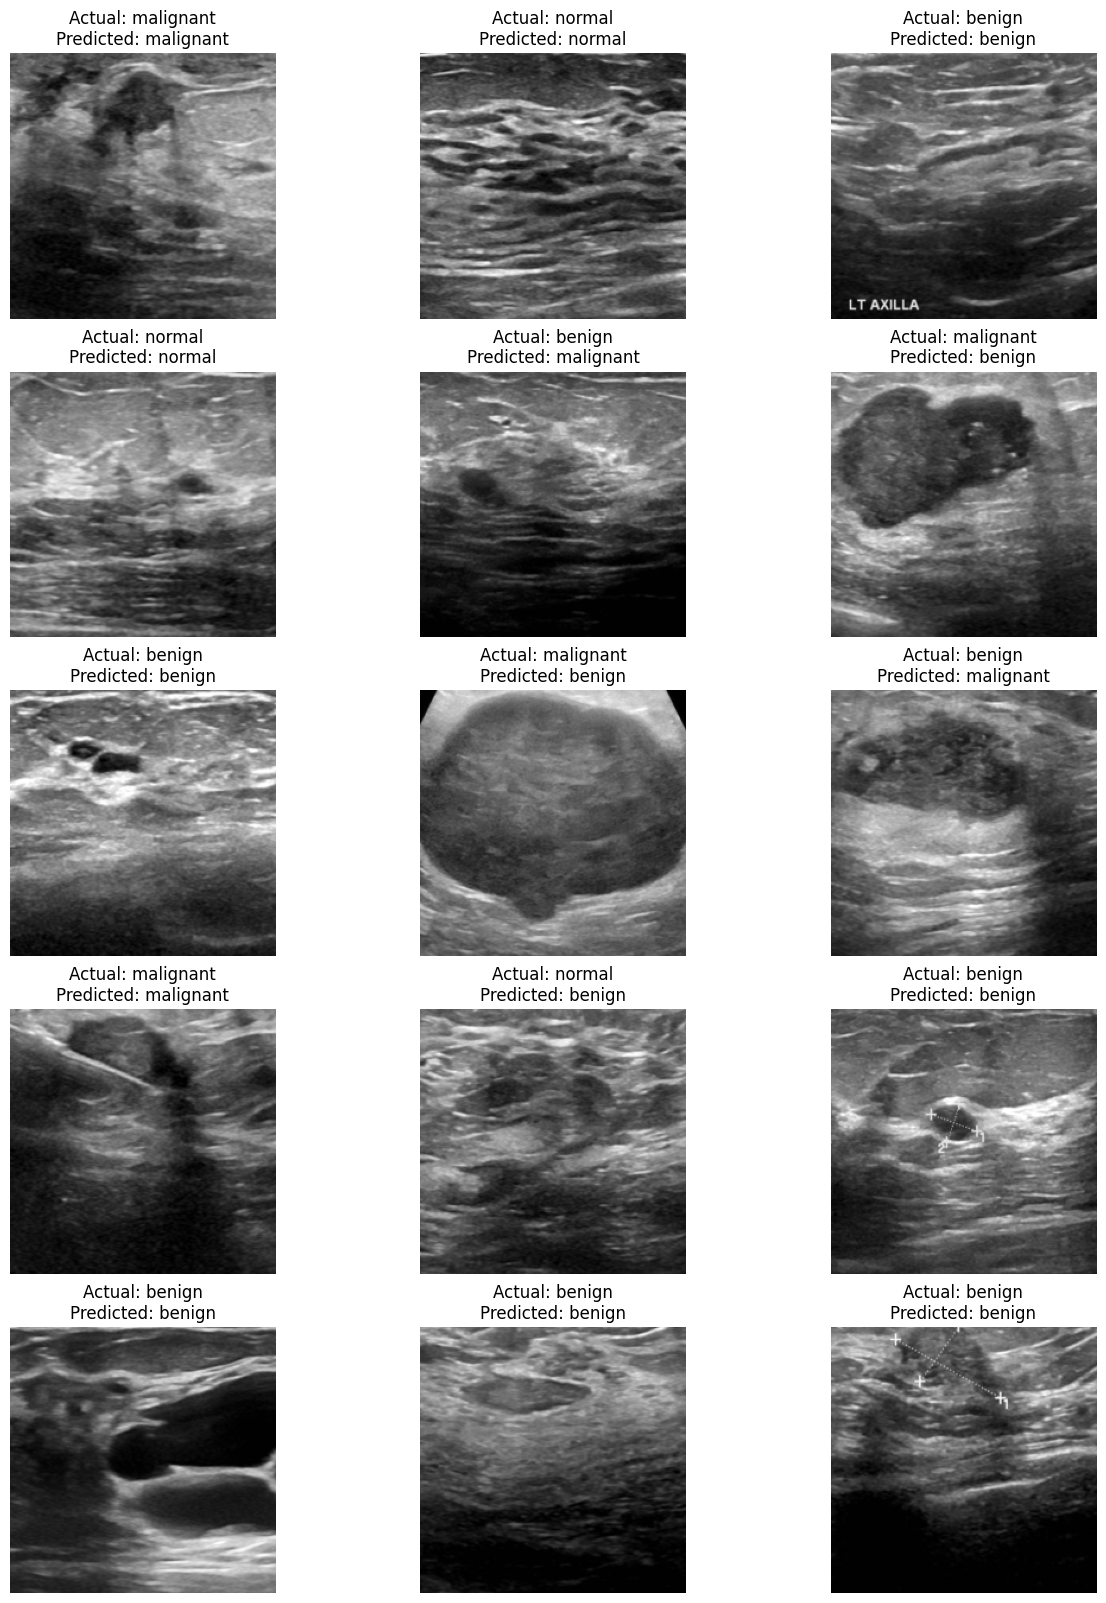

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

num_images_to_display = 15

test_dataloader = DataLoader(image_datasets['test'], batch_size=num_images_to_display, shuffle=True, num_workers=4)

inputs, labels = next(iter(test_dataloader))

inputs = inputs.to(device)

grayscale_images = inputs.cpu().numpy().mean(axis=1)

with torch.no_grad():
    model_fineTuning.eval()
    outputs = model_fineTuning(inputs)
    _, preds = torch.max(outputs, 1)

plt.figure(figsize=(15, 20))
for i in range(num_images_to_display):
    ax = plt.subplot(5, 3, i + 1)
    ax.axis('off')
    ax.set_title(f'Actual: {class_names[labels[i]]}\nPredicted: {class_names[preds[i]]}')
    plt.imshow(grayscale_images[i], cmap='gray')

plt.show()


Approach 2

In [ ]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ResourceWarning)

input_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'

output_dir = '/kaggle/working/OverlayedImages'

labels = ['benign', 'malignant', 'normal']
for label in labels:
    os.makedirs(os.path.join(output_dir, label), exist_ok=True)

def overlay_and_save(image_path, mask_path, output_path):
    try:
        if os.path.exists(image_path) and os.path.exists(mask_path):
            image = Image.open(image_path)
            mask = Image.open(mask_path)

            if image.mode != mask.mode:
                mask = mask.convert(image.mode)

            if image.size != mask.size:
                image = image.resize(mask.size)

            overlayed = Image.blend(image, mask, alpha=0.5)

            label = os.path.basename(os.path.dirname(image_path))
            output_path = os.path.join(output_dir, label, os.path.basename(image_path))
            overlayed.save(output_path)
        else:
            pass
    except Exception as e:
        print(f"An error occurred for: {image_path} or {mask_path}. Error: {str(e)}")

for label in labels:
    label_dir = os.path.join(input_dir, label)
    if os.path.isdir(label_dir):
        for image_filename in os.listdir(label_dir):
            if image_filename.endswith('.png'):
                image_path = os.path.join(label_dir, image_filename)
                mask_filename = image_filename.replace('.png', '_mask.png')
                mask_path = os.path.join(label_dir, mask_filename)
                overlay_and_save(image_path, mask_path, output_dir)

print("Overlayed images have been saved to /kaggle/working/OverlayedImages directory.")

Overlayed images have been saved to /kaggle/working/OverlayedImages directory.


In [ ]:
import os

def count_files_in_directory(directory):
    return sum(len(files) for _, _, files in os.walk(directory))

input_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
output_dir = '/kaggle/working/OverlayedImages'

input_counts = {}
output_counts = {}

for label in os.listdir(input_dir):
    label_dir = os.path.join(input_dir, label)
    if os.path.isdir(label_dir):
        input_counts[label] = count_files_in_directory(label_dir)

for label in os.listdir(output_dir):
    label_dir = os.path.join(output_dir, label)
    if os.path.isdir(label_dir):
        output_counts[label] = count_files_in_directory(label_dir)

print("File Counts Before Overlay-includes masks:")
for label, count in input_counts.items():
    print(f"{label}: {count} files")

print("\nFile Counts After Overlay:")
for label, count in output_counts.items():
    print(f"{label}: {count} files")

File Counts Before Overlay-includes masks:
benign: 891 files
malignant: 421 files
normal: 266 files

File Counts After Overlay:
benign: 437 files
malignant: 210 files
normal: 133 files


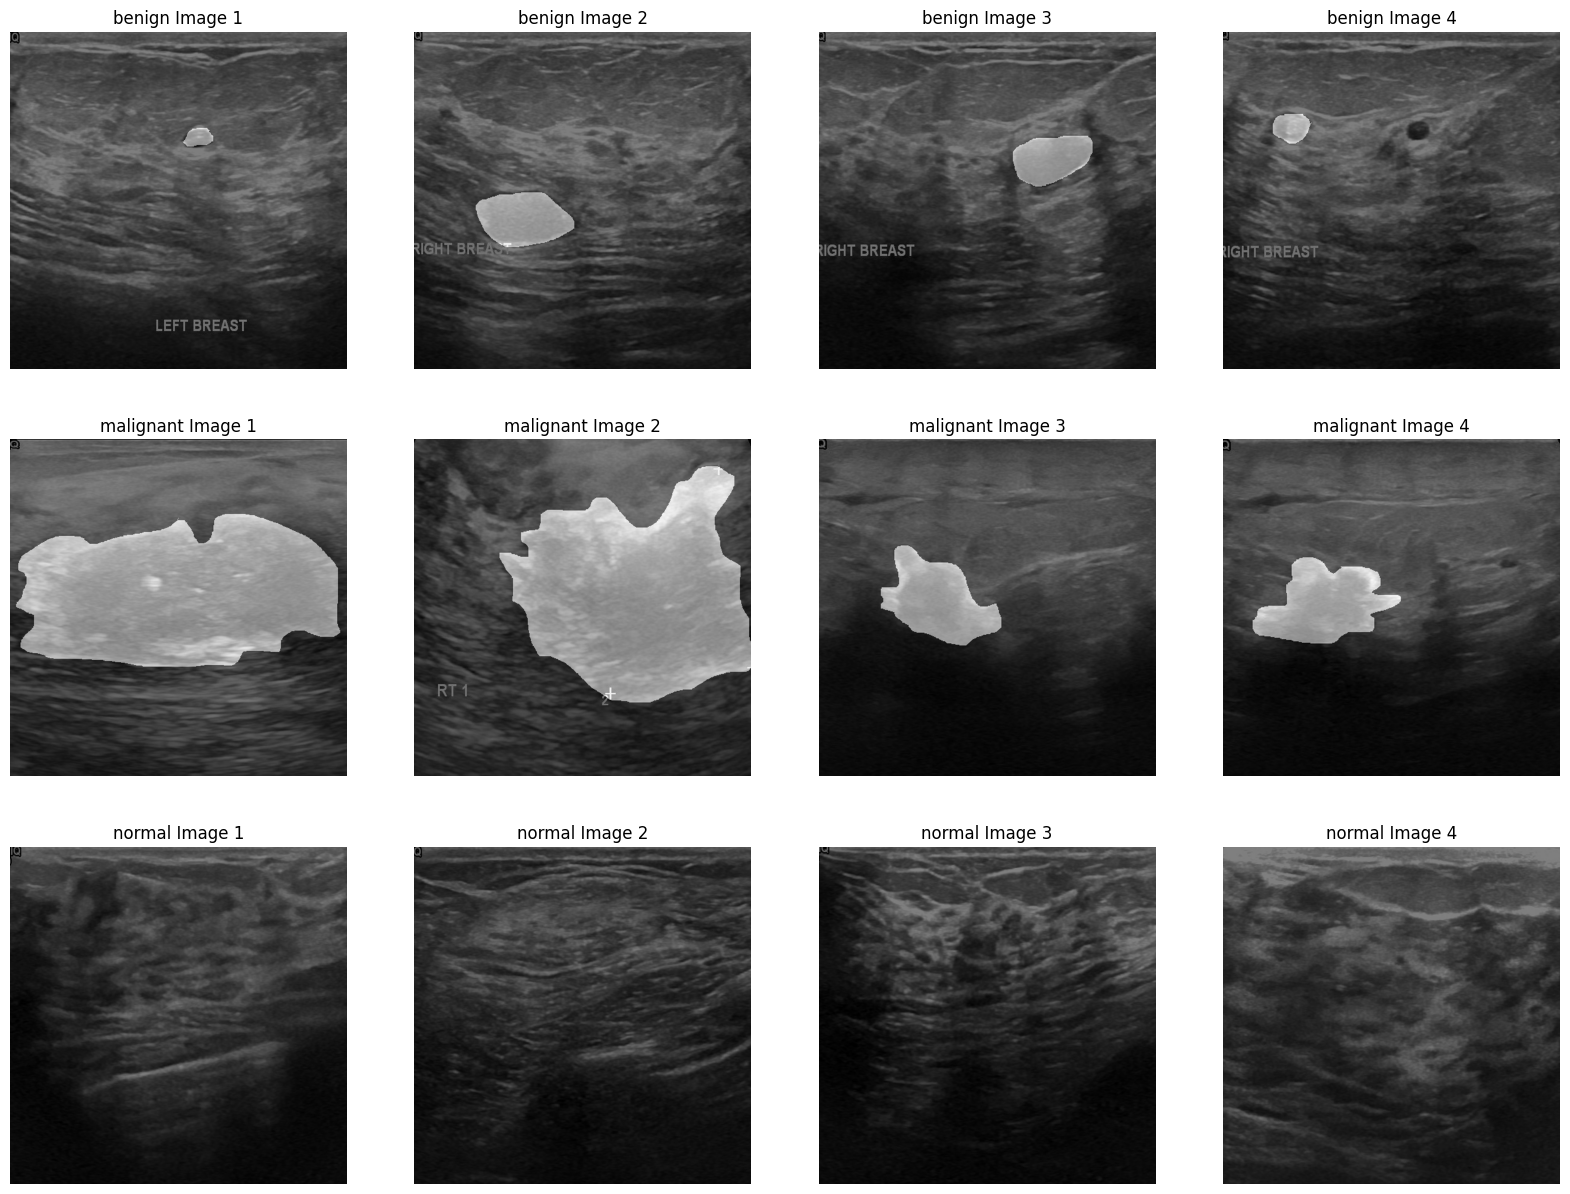

In [ ]:
overlayed_dir = '/kaggle/working/OverlayedImages'

labels = ['benign', 'malignant', 'normal']
label_dirs = [os.path.join(overlayed_dir, label) for label in labels]

fig, axs = plt.subplots(3, 4, figsize=(20, 15))

desired_width = 800
desired_height = 800

for i, label_dir in enumerate(label_dirs):
    images = [image for image in os.listdir(label_dir) if image.endswith('.png')]
    images.sort(key=lambda x: int(x.split('(')[1].split(')')[0]))

    for j, image_filename in enumerate(images[:4]):
        image_path = os.path.join(label_dir, image_filename)
        image = Image.open(image_path)
        image = image.resize((desired_width, desired_height), Image.ANTIALIAS)

        axs[i, j].imshow(image)
        axs[i, j].set_title(f'{labels[i]} Image {j + 1}')
        axs[i, j].axis('off')

plt.show()

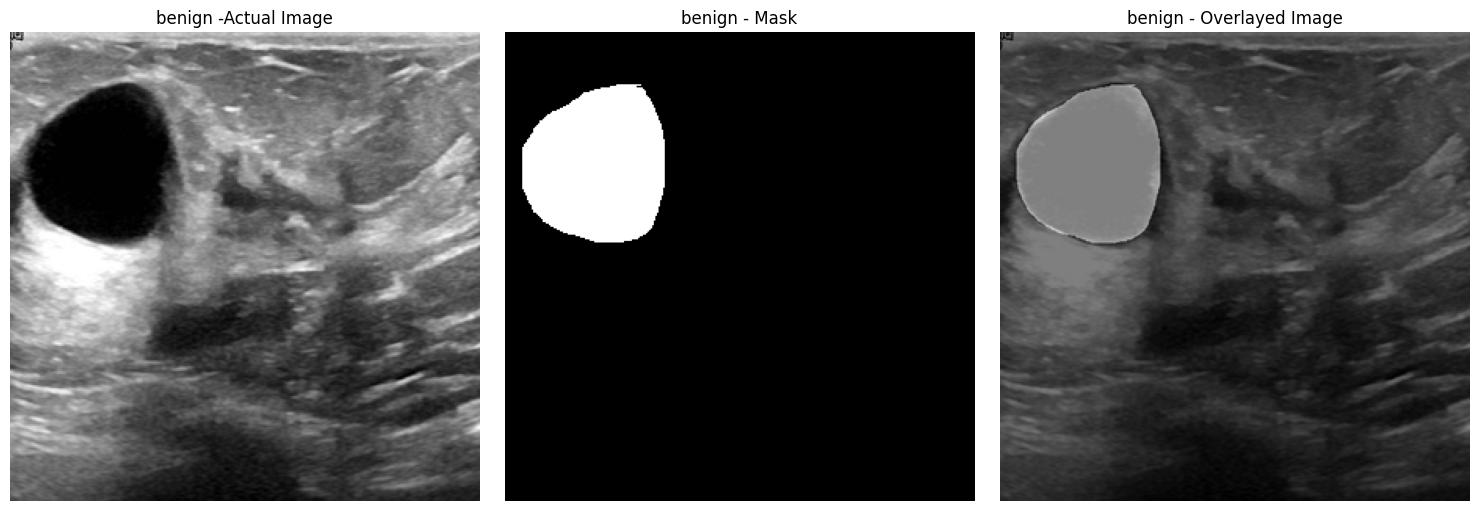

In [ ]:

input_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
overlayed_dir = '/kaggle/working/OverlayedImages/benign'

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

desired_width = 300
desired_height = 300

image_filename = 'benign (10).png'

actual_image_path = os.path.join(input_dir, 'benign', image_filename)
mask_image_path = os.path.join(input_dir, 'benign', image_filename.replace(".png", "_mask.png"))
overlayed_image_path = os.path.join(overlayed_dir, image_filename)

actual_image = Image.open(actual_image_path)
mask_image = Image.open(mask_image_path)
overlayed_image = Image.open(overlayed_image_path)

actual_image = actual_image.resize((desired_width, desired_height), Image.ANTIALIAS)
mask_image = mask_image.resize((desired_width, desired_height), Image.ANTIALIAS)
overlayed_image = overlayed_image.resize((desired_width, desired_height), Image.ANTIALIAS)

axs[0].imshow(actual_image)
axs[0].set_title('benign -Actual Image')
axs[0].axis('off')

axs[1].imshow(mask_image, cmap='gray')
axs[1].set_title('benign - Mask')
axs[1].axis('off')

axs[2].imshow(overlayed_image)
axs[2].set_title('benign - Overlayed Image')
axs[2].axis('off')

plt.tight_layout()
plt.show()


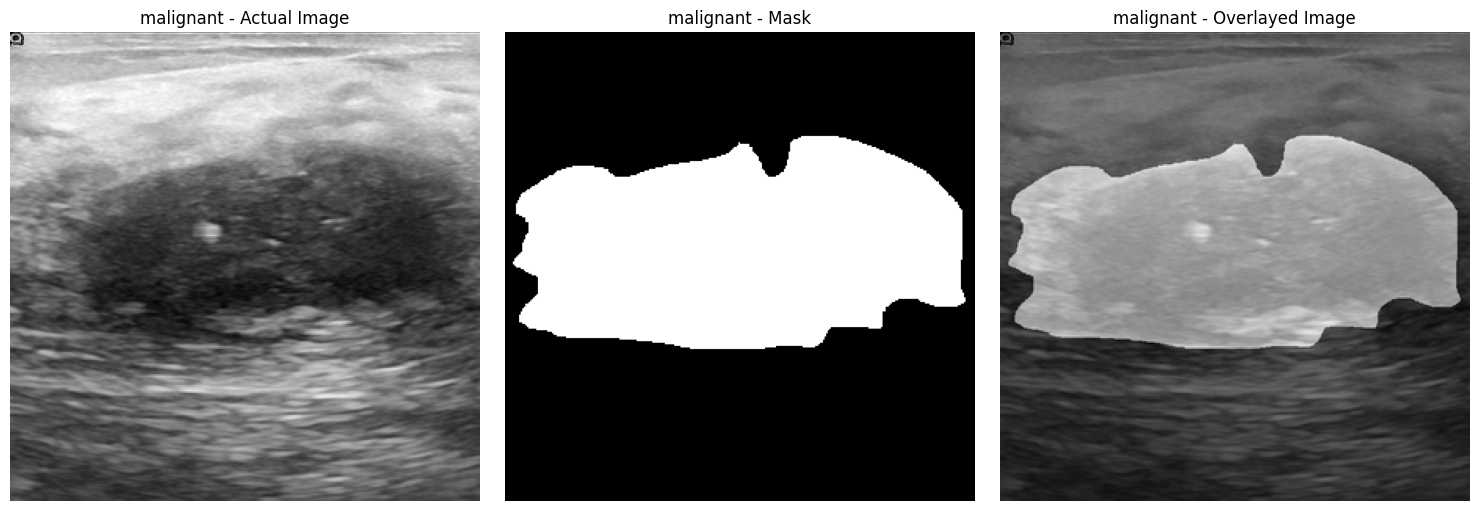

In [ ]:

input_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
overlayed_dir = '/kaggle/working/OverlayedImages/malignant'

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

desired_width = 300
desired_height = 300

image_filename = 'malignant (1).png'

actual_image_path = os.path.join(input_dir, 'malignant', image_filename)
mask_image_path = os.path.join(input_dir, 'malignant', image_filename.replace(".png", "_mask.png"))
overlayed_image_path = os.path.join(overlayed_dir, image_filename)

actual_image = Image.open(actual_image_path)
mask_image = Image.open(mask_image_path)
overlayed_image = Image.open(overlayed_image_path)

actual_image = actual_image.resize((desired_width, desired_height), Image.ANTIALIAS)
mask_image = mask_image.resize((desired_width, desired_height), Image.ANTIALIAS)
overlayed_image = overlayed_image.resize((desired_width, desired_height), Image.ANTIALIAS)

axs[0].imshow(actual_image)
axs[0].set_title('malignant - Actual Image')
axs[0].axis('off')

axs[1].imshow(mask_image, cmap='gray')
axs[1].set_title('malignant - Mask')
axs[1].axis('off')

axs[2].imshow(overlayed_image)
axs[2].set_title('malignant - Overlayed Image')
axs[2].axis('off')

plt.tight_layout()
plt.show()

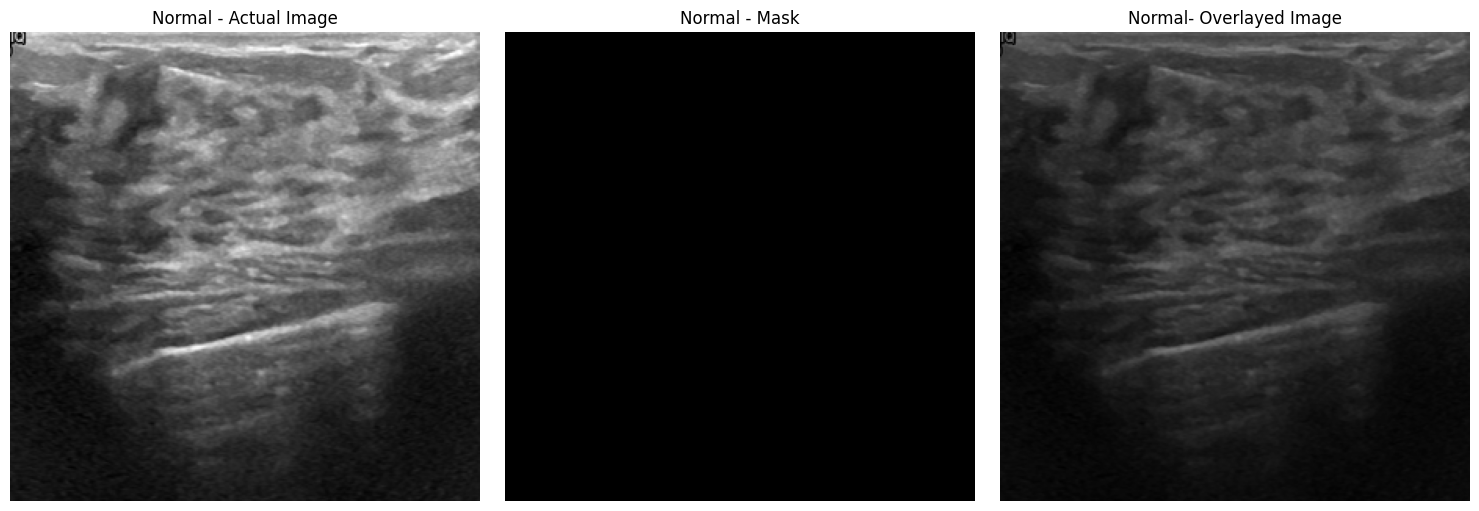

In [ ]:

input_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
overlayed_dir = '/kaggle/working/OverlayedImages/normal'

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

desired_width = 300
desired_height = 300

image_filename = 'normal (1).png'

actual_image_path = os.path.join(input_dir, 'normal', image_filename)
mask_image_path = os.path.join(input_dir, 'normal', image_filename.replace(".png", "_mask.png"))
overlayed_image_path = os.path.join(overlayed_dir, image_filename)

actual_image = Image.open(actual_image_path)
mask_image = Image.open(mask_image_path)
overlayed_image = Image.open(overlayed_image_path)

actual_image = actual_image.resize((desired_width, desired_height), Image.ANTIALIAS)
mask_image = mask_image.resize((desired_width, desired_height), Image.ANTIALIAS)
overlayed_image = overlayed_image.resize((desired_width, desired_height), Image.ANTIALIAS)

axs[0].imshow(actual_image)
axs[0].set_title('Normal - Actual Image')
axs[0].axis('off')

axs[1].imshow(mask_image, cmap='gray')
axs[1].set_title('Normal - Mask')
axs[1].axis('off')

axs[2].imshow(overlayed_image)
axs[2].set_title('Normal- Overlayed Image')
axs[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
class_names = ['malignant', 'normal','benign']
minority_classes = ['malignant', 'normal']

minority_class_transforms = transforms.Compose([
    RandomHorizontalFlip(p=0.9),
    RandomRotation(15, expand=False, center=None),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomApply([minority_class_transforms], p=0.5) if any(cls in minority_classes for cls in class_names) else transforms.RandomApply([], p=0.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:

data_dir = '/kaggle/working/OverlayedImages'

file_paths = []
labels = []

for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for image_file in os.listdir(label_dir):
            if image_file.endswith('.png') and not (image_file.endswith('_mask.png') or
                                                     image_file.endswith('_mask_1.png') or
                                                     image_file.endswith('_mask_2.png')):
                image_path = os.path.join(label_dir, image_file)
                labels.append(label)
                file_paths.append(image_path)

data = pd.DataFrame({'Image_Path': file_paths, 'Label': labels})

train_data, test_data = train_test_split(data, test_size=0.15, random_state=42, stratify=data['Label'])
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42, stratify=train_data['Label'])

train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/validation'
test_dir = '/kaggle/working/test'

for label in labels:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

for _, row in train_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(train_dir, label))

for _, row in val_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(val_dir, label))

for _, row in test_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(test_dir, label))

In [ ]:
import os
train_dir = '/kaggle/working/train'

subdirectories = ['benign', 'malignant', 'normal']

file_counts = {}

for subdirectory in subdirectories:
    subdirectory_path = os.path.join(train_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

for category, count in file_counts.items():
    print(f"Train {category}: {count}")

validation_dir = '/kaggle/working/validation'

subdirectories = ['benign', 'malignant', 'normal']

file_counts = {}

for subdirectory in subdirectories:
    subdirectory_path = os.path.join(validation_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

for category, count in file_counts.items():
    print(f"Validation {category}: {count}")


test_dir = '/kaggle/working/test'

subdirectories = ['benign', 'malignant', 'normal']

file_counts = {}

for subdirectory in subdirectories:
    subdirectory_path = os.path.join(test_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

for category, count in file_counts.items():

    print(f"test {category}: {count}")

Train benign: 315
Train malignant: 152
Train normal: 96
Validation benign: 56
Validation malignant: 27
Validation normal: 17
test benign: 66
test malignant: 31
test normal: 20


In [ ]:
data_dir='/kaggle/working/'

image_datasets = {
    x: ImageFolder(
        root=os.path.join(data_dir, x),
        transform=data_transforms[x]
    )
    for x in ['train', 'validation', 'test']
}

batch_size = 8

dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
               for x in ['train', 'validation', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}

class_names = image_datasets['train'].classes

print("Dataset Sizes:", dataset_sizes)
print("Class Labels:", class_names)

Dataset Sizes: {'train': 563, 'validation': 100, 'test': 117}
Class Labels: ['benign', 'malignant', 'normal']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
Resnet101 = models.resnet101(weights=True)

print(Resnet101)

for param in Resnet101.parameters():
    param.requires_grad = True

in_features = Resnet101.fc.in_features

Resnet101.fc = nn.Linear(in_features, len(class_names))

Resnet_fineTuning = Resnet101.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:

optimizer = optim.Adam(Resnet_fineTuning.parameters(), lr=0.00005)

Decay_Learning_Rate = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Loss_Function = nn.CrossEntropyLoss()

In [ ]:
model_fineTuning, train_losses, train_accuracies, val_losses, val_accuracies = train_model_with_early_stopping(
    Resnet_fineTuning, Loss_Function, optimizer, Decay_Learning_Rate,
    dataloaders, dataset_sizes, class_names, device, num_epochs=20, patience=2)
torch.save(model_fineTuning, "/kaggle/working/Resnet_fineTuning.pth")

Epoch 0/19
----------
train Loss: 0.3058 Acc: 0.9076
validation Loss: 0.1537 Acc: 0.9400

Epoch 1/19
----------
train Loss: 0.1594 Acc: 0.9503
validation Loss: 0.0788 Acc: 0.9900

Epoch 2/19
----------
train Loss: 0.1009 Acc: 0.9769
validation Loss: 0.1366 Acc: 0.9600

Epoch 3/19
----------
train Loss: 0.1170 Acc: 0.9627
validation Loss: 0.1810 Acc: 0.9500
Early stopping after 3 epochs
Training complete in 1m 10s
Best val Loss: 0.0788
              precision    recall  f1-score   support

      benign       0.98      1.00      0.99        56
   malignant       1.00      0.96      0.98        27
      normal       1.00      1.00      1.00        17

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

Confusion Matrix:
[[56  0  0]
 [ 1 26  0]
 [ 0  0 17]]


0.5808827877044678 0.7987217903137207 0.42437875270843506 0.7828586101531982 0.4940437078475952 0.5580812096595764 0.45148271322250366 0.36217907071113586 0.2772279977798462 0.7007983922958374 0.5556650757789612 0.22598201036453247 0.5389198660850525 0.3401188552379608 0.5907458662986755 0.24074749648571014 0.4958864450454712 0.345072865486145 0.3825492560863495 0.1723511666059494 0.13644471764564514 0.11188580095767975 0.17563660442829132 0.37814953923225403 0.16042867302894592 0.38008418679237366 0.4141741394996643 1.2668200731277466 0.3211088478565216 0.16008126735687256 0.12155864387750626 0.6280722618103027 0.5571584701538086 0.059059273451566696 0.3496219515800476 0.5963215231895447 0.35308724641799927 0.42664259672164917 0.4663466811180115 0.15691673755645752 0.20570749044418335 0.7509090900421143 0.2594948410987854 0.07541804015636444 0.11190999299287796 0.07164613902568817 0.04761752486228943 0.49131321907043457 0.07112651318311691 0.18365709483623505 0.03904830664396286 0.083

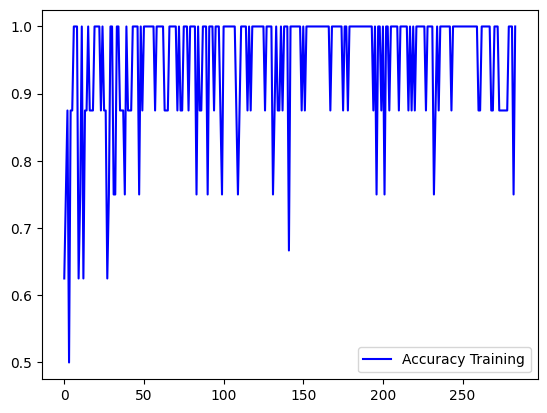

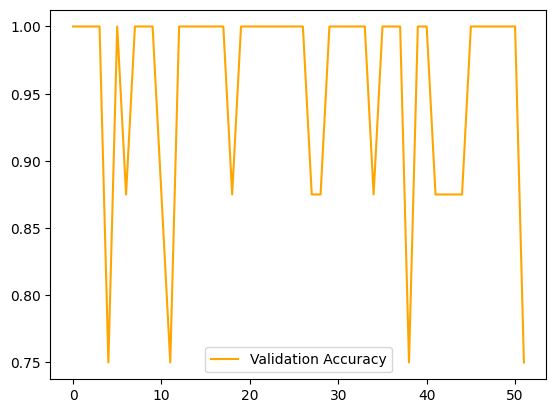

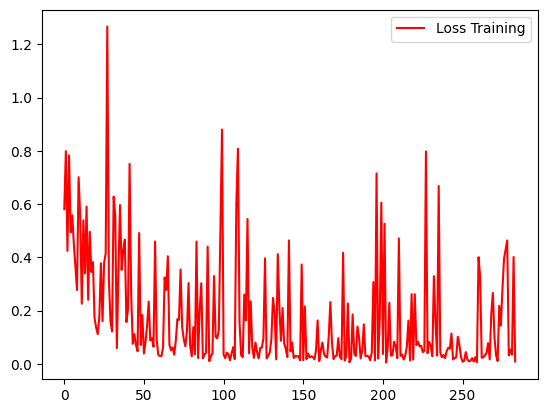

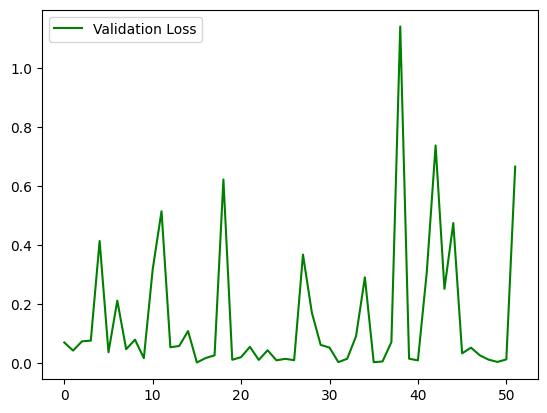

In [ ]:
import matplotlib.pyplot as plt

print(*train_losses)
print(len(train_losses))
print(*train_accuracies)
print(len(train_accuracies))
print(*val_losses)
print(len(val_losses))
print(*val_accuracies)
print(len(val_accuracies))


plt.plot(train_accuracies,label="Accuracy Training",color='blue')
plt.legend()
plt.show()
print("\n")
plt.plot(val_accuracies,label="Validation Accuracy",color='orange')
plt.legend()
plt.show()
print("\n")
plt.plot(train_losses,label="Loss Training",color='red')
plt.legend()
plt.show()
print("\n")
plt.plot(val_losses,label="Validation Loss",color='green')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


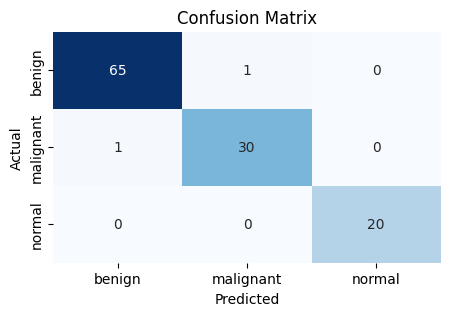

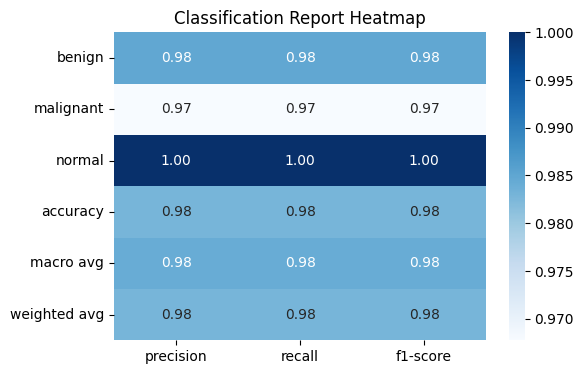

Simplified Classification Report:
             benign  malignant  normal  accuracy  macro avg  weighted avg
precision  0.984848   0.967742     1.0  0.982906   0.984197      0.982906
recall     0.984848   0.967742     1.0  0.982906   0.984197      0.982906
f1-score   0.984848   0.967742     1.0  0.982906   0.984197      0.982906


In [ ]:
label_names = [str(class_names[i]) for i in range(len(class_names))]

y_true = []
y_pred = []

model_fineTuning.eval()

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_fineTuning(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

classification_rep = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)

confusion_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print("\n")
plt.figure(figsize=(6, 4))
sns.heatmap(pd.DataFrame(classification_rep).iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f')  # Simplify classification report
plt.title('Classification Report')
plt.show()
print("\n")
print("Simplified Classification Report:")
print(pd.DataFrame(classification_rep).iloc[:-1, :])

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


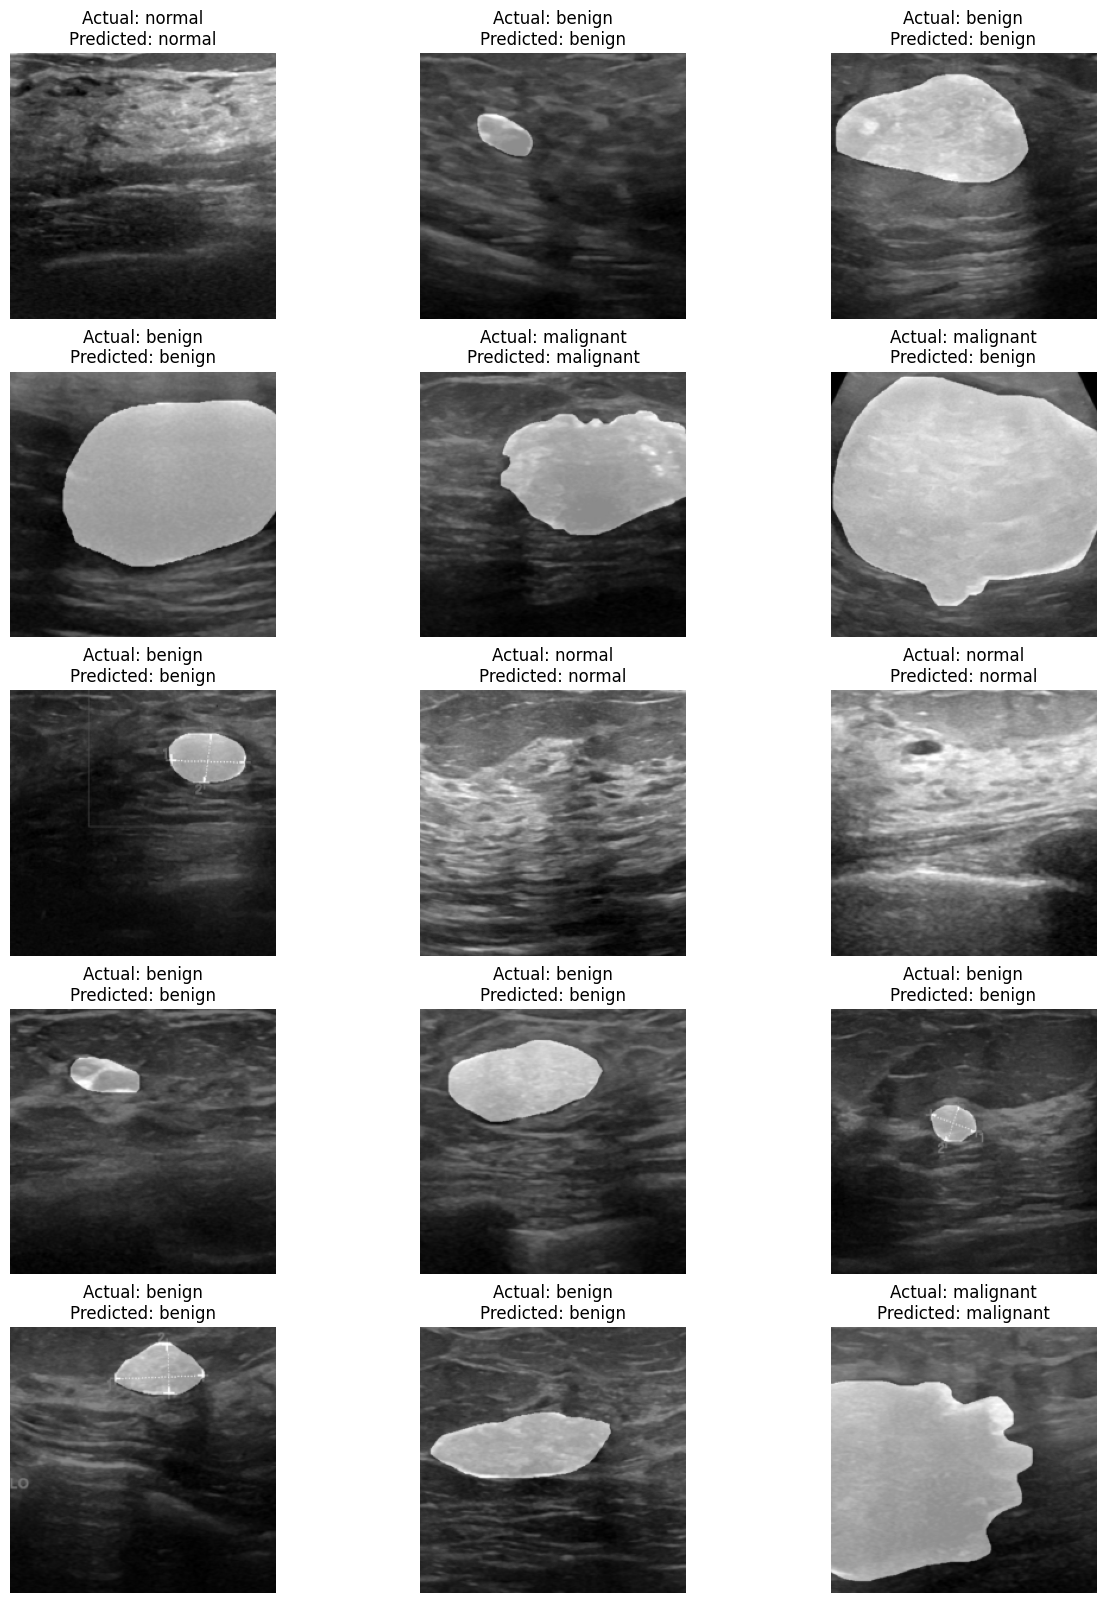

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

num_images_to_display = 15

test_dataloader = DataLoader(image_datasets['test'], batch_size=num_images_to_display, shuffle=True, num_workers=4)

inputs, labels = next(iter(test_dataloader))

inputs = inputs.to(device)

grayscale_images = inputs.cpu().numpy().mean(axis=1)  # Convert RGB to grayscale

with torch.no_grad():
    model_fineTuning.eval()
    outputs = model_fineTuning(inputs)
    _, preds = torch.max(outputs, 1)

plt.figure(figsize=(15, 20))
for i in range(num_images_to_display):
    ax = plt.subplot(5, 3, i + 1)
    ax.axis('off')
    ax.set_title(f'Actual: {class_names[labels[i]]}\nPredicted: {class_names[preds[i]]}')
    plt.imshow(grayscale_images[i], cmap='gray')

plt.show()
